## CNN Training

Train a CNN network to extract the needle position of an analog pointer

### Basic Parameter

Note: Do not rename any of the variables in this section, because the they are externally used in github action `Train Model`

In [1]:
# Model naming
TFlite_MainType: str = 'ana-cont'
TFlite_Version: str  = '1800'
TFlite_Size: str     = 's1'

# Validation size
# Note: 0.0 = 0% validation size, use all images for training
Validation_Percentage = 0.2

# Folders
Input_Dir: str  = 'data_resize_all'
Output_Dir: str = 'models/ana-cont'


### Libaries and defaults

In [2]:
import os
import sys
import glob
from pathlib import Path
import numpy as np
import random
import math
from PIL import Image 

import tensorflow as tf

from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from src.utils.plot_functions import plot_dataset, plot_dataset_analog


%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)


# Make sure version is 4 characters long if version is defined as int (e.g. papermill paramter 100 -> 0100)
if isinstance(TFlite_Version, int):
    TFlite_Version = str(TFlite_Version).zfill(4)


# Prepare folders
if not (Path(Input_Dir).exists() and Path(Input_Dir).is_dir()): # Check if input is availabe
    sys.exit(f"Aborting: Folder '{Input_Dir}' does not exist.")
    
Path(Output_Dir).mkdir(parents=True, exist_ok=True)  # Create output folder if it doesn't exist


# Disable GPUs
try:
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass


### Load training data
* The data is expected in the "Input_dir"
* Picture size must be 32x32 with 3 color channels (RGB)
* The filename contains the informations needed for training in the first 3 digits::
* Typical filename: 
    * x.y-zzzz.jpg 
    * e.g. "4.6_Lfd-1406_zeiger3_2019-06-02T050011.jpg"

|Place holder | Meaning                     | Usage             |
|-------------|-----------------------------|-------------------|
| **x.y**     | readout value               | **to be learned** |
| zzzz        | additional information      | not needed        |

* The images are stored in the x_data[]
* The expected output for each image in the corresponding y_data[]
    * The periodic nature is reflected in a **sin/cos coding**, which allows to restore the angle/counter value with an arctan later on.

* The last step is a shuffle (from sklearn.utils) as the filenames are on order due to the encoding of the expected analog readout in the filename 

In [3]:
files = glob.glob(f"{Input_Dir}/*.jpg")
num_files = len(files)

x_data = np.zeros((num_files, 32, 32, 3), dtype="float32")
y_data = np.zeros((num_files, 2), dtype="float32")

for idx, aktfile in enumerate(files):
    test_image = Image.open(aktfile)
    #test_image = np.array(test_image.resize((32, 32), Image.LANCZOS), dtype="float32")  # Resize while loading
    test_image = np.array(test_image, dtype="float32")  # No resizing
    base = Path(aktfile).name
    target_number = float(base[:3]) / 10
    target_sin = math.sin(target_number * math.pi * 2)
    target_cos = math.cos(target_number * math.pi * 2)

    # Store image and target values
    x_data[idx] = test_image
    y_data[idx] = [target_sin, target_cos]

x_data, y_data = shuffle(x_data, y_data)

if Validation_Percentage > 0:
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Validation_Percentage)
else:
    x_train = x_data
    y_train = y_data

print(x_data.shape)
print(y_data.shape)


(2493, 32, 32, 3)
(2493, 2)


### Define the model

##### Important
* Shape of the input layer: (32, 32, 3)
* Shape of the output layer: (2) - sin and cos

In [4]:
input = tf.keras.Input(shape=(32, 32, 3))

x = BatchNormalization()(input)
x = Conv2D(16, (3, 3), padding='same', activation="relu")(x)
x = MaxPool2D(pool_size=(2, 2))(x)

x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), padding='same', activation="relu")(x)
x = MaxPool2D(pool_size=(2, 2))(x)

x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), padding='same', activation="relu")(x)
x = MaxPool2D(pool_size=(2, 2))(x)

x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), padding='same', activation="relu")(x)
x = MaxPool2D(pool_size=(2, 2))(x)

x = Flatten()(x)

x = BatchNormalization()(x)
x = Dense(128, activation="relu", kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.3)(x)

x = Dense(64, activation="relu", kernel_regularizer=l2(1e-4))(x)

output = Dense(2)(x)

model = tf.keras.Model(inputs=input, outputs=output)
model.compile(
    loss="mse",
    optimizer=Adam(learning_rate=1e-3),
    metrics=["mse"]
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,278 (403.43 KB)

 Trainable params: 102,536 (400.53 KB)

 Non-trainable params: 742 (2.90 KB)

### Training

Training data


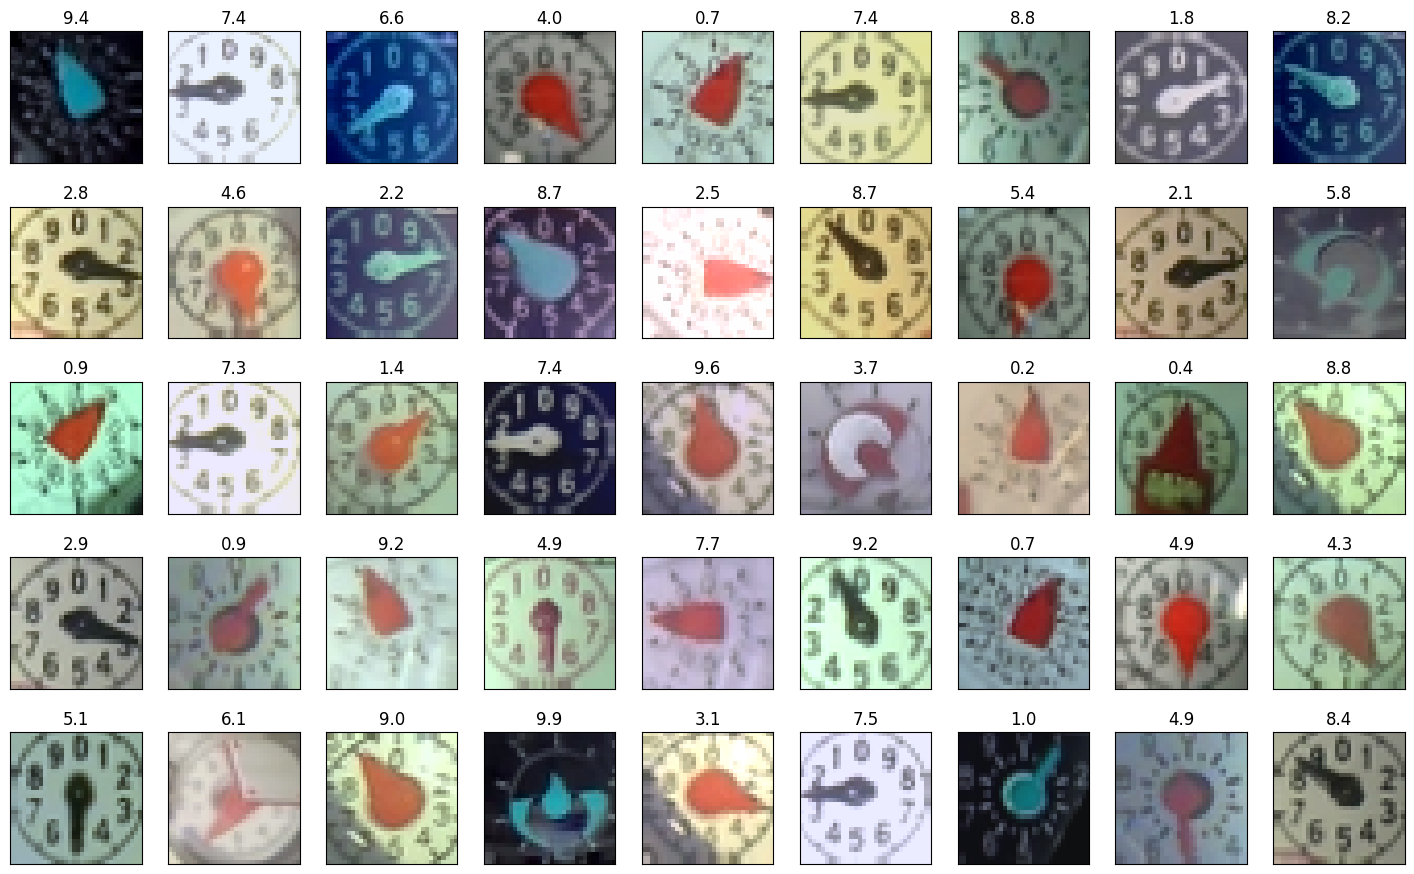

  
Validation data


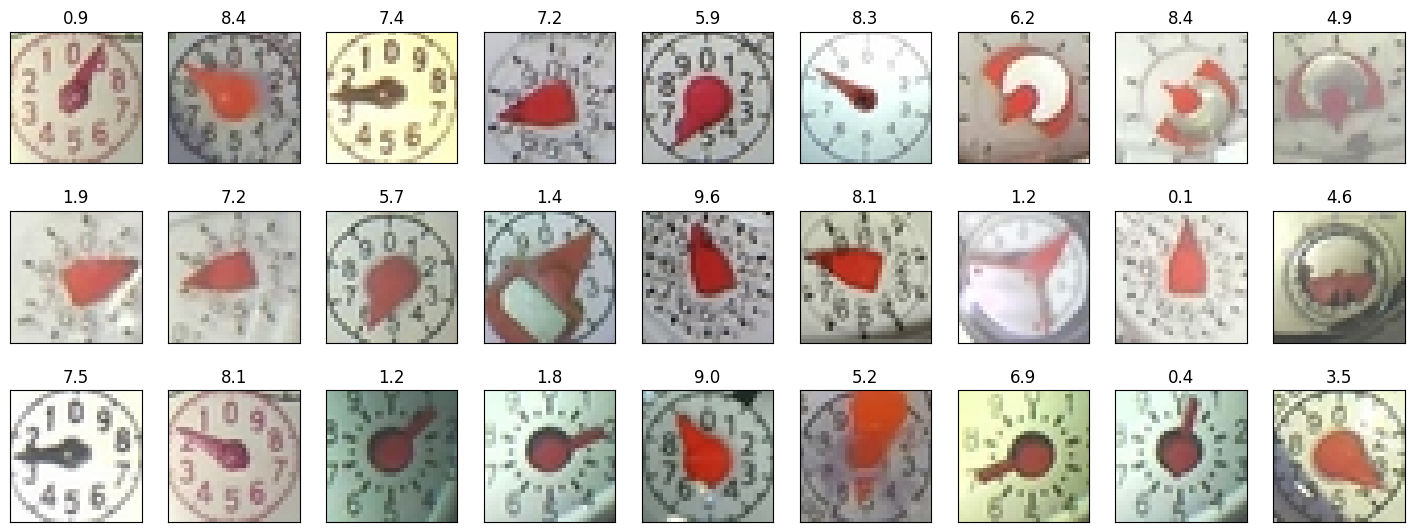

In [5]:
Batch_Size = 8
Shift_Range = 1
Brightness_Range = 0.2
Zoom_Range = 0.05

def random_invert_image(x, probability_invert=0.2):
    """
    Invert an image with a given probability
    """
    if random.random() > probability_invert:
        return x
    return 255 - x  # Invert image

def random_white_balance(x, strength_range=(0.9, 1.1)):
    """
    Simulates poor white balance by randomly scaling RGB channels independently.
    strength_range controls how strong the color cast distortion is.
    """
    x = x.astype(np.float32)

    # Random scaling for each channel (simulates color cast)
    r_scale = np.random.uniform(*strength_range)
    g_scale = np.random.uniform(*strength_range)
    b_scale = np.random.uniform(*strength_range)

    x[..., 0] *= r_scale  # Red channel
    x[..., 1] *= g_scale  # Green channel
    x[..., 2] *= b_scale  # Blue channel

    return x

def preprocessing(x):
    x = random_invert_image(x)
    x = random_white_balance(x)
    x = np.clip(x, 0.0, 255.0)
    return x.astype(np.float32)

# Training data
print("Training data")
datagen = ImageDataGenerator(width_shift_range=[-Shift_Range, Shift_Range], 
                             height_shift_range=[-Shift_Range, Shift_Range],
                             brightness_range=[1 - Brightness_Range, 1 + Brightness_Range],
                             zoom_range=[1 - Zoom_Range, 1 + Zoom_Range],
                             channel_shift_range=5,
                             shear_range=1,
                             preprocessing_function=preprocessing
                            )

train_iterator = datagen.flow(x_train, y_train, batch_size=Batch_Size)
plot_dataset_analog(train_iterator)     

if (Validation_Percentage > 0):
    # Validation data
    datagen_val = ImageDataGenerator() # No augmentation for validation
    validation_iterator = datagen_val.flow(x_test, y_test, batch_size=Batch_Size)
    print("  ")
    print("Validation data")
    plot_dataset_analog(validation_iterator, rows=3)


In [6]:
Epoch_Anz = 600

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.9, patience=5, min_lr=1e-5
)

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss', mode='min', patience=25, restore_best_weights=True
)

if (Validation_Percentage > 0):
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz, callbacks=[lr_scheduler, early_stopping], verbose=0)
else:
    history = model.fit(train_iterator, epochs = Epoch_Anz, callbacks=[lr_scheduler, early_stopping], verbose=0)


C:\Users\Muell\anaconda3\envs\py311-tf218\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


### Results

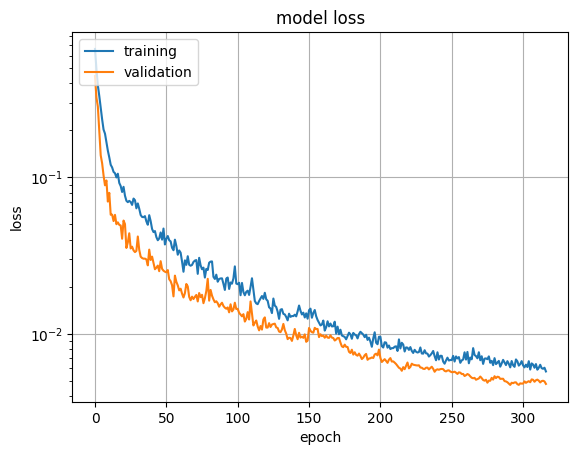

In [7]:
plt.semilogy(history.history['loss'])

if (Validation_Percentage > 0):
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='upper left')
plt.grid(True)
plt.show()


### Model verification

* The following code uses the trained model to check the deviation for each picture.
* Images, that have a bigger deviation as the parameter "deviation_max_list" are printed in a list to check the picture and labeling itself

In [8]:
files = glob.glob(Input_Dir + '/*.*')
res = []
i = 0
deviation_max_list = 0.11

for aktfile in sorted(files):
    base = os.path.basename(aktfile)
    target = (float(base[0:3])) / 10
    
    target_sin = math.sin(target * math.pi * 2)
    target_cos = math.cos(target * math.pi * 2)

    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    img = np.reshape(test_image,[1,32,32,3])
    classes = model.predict(img, verbose=0)
    
    out_sin = classes[0][0]  
    out_cos = classes[0][1]
    out_target = (np.arctan2(out_sin, out_cos)/(2*math.pi)) % 1

    dev_target = target - out_target
    
    if abs(dev_target + 1) < abs(dev_target):
        out_target = out_target - 1
        dev_target = target - out_target
    else:
        if abs(dev_target - 1) < abs(dev_target):
            out_target = out_target + 1
            dev_target = target - out_target
               
    if abs(dev_target) > deviation_max_list:
        log_devition = aktfile + " " + str(target) + " " + str(out_target) +  " " + str(dev_target)
        print(log_devition)

        # Save to file
        with open(f"{Output_Dir}/false_predictions.txt", "a") as f:  # 'a' to append
            f.write(log_devition + "\n")
    
    res.append(np.array([target, out_target, dev_target, out_sin, out_cos, i]))

res = np.asarray(res)


### Results

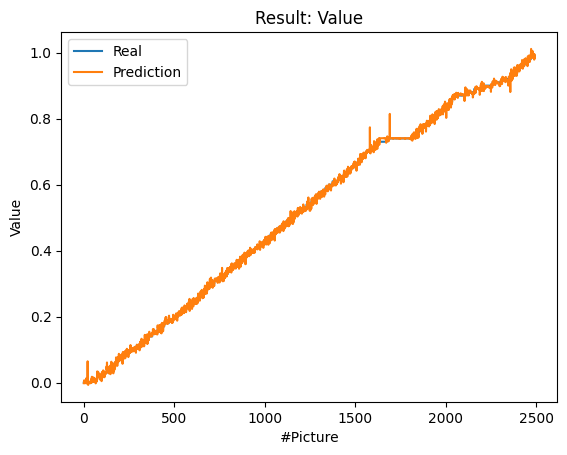

In [9]:
plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result: Value')
plt.ylabel('Value')
plt.xlabel('#Picture')
plt.legend(['Real', 'Prediction'], loc='upper left')
plt.show()


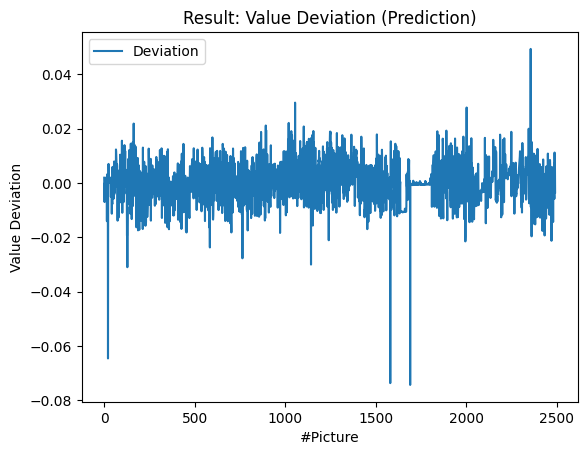

[ 0.0003  0.0075 -0.0744  0.0493]


In [10]:
plt.plot(res[:,2])
plt.title('Result: Value Deviation (Prediction)')
plt.ylabel('Value Deviation')
plt.xlabel('#Picture')
plt.legend(['Deviation'], loc='upper left')
#plt.ylim(-0.3, 0.3)
plt.show()

statistic = np.array([np.mean(res[:,2]), np.std(res[:,2]), np.min(res[:,2]), np.max(res[:,2])])
print(statistic)


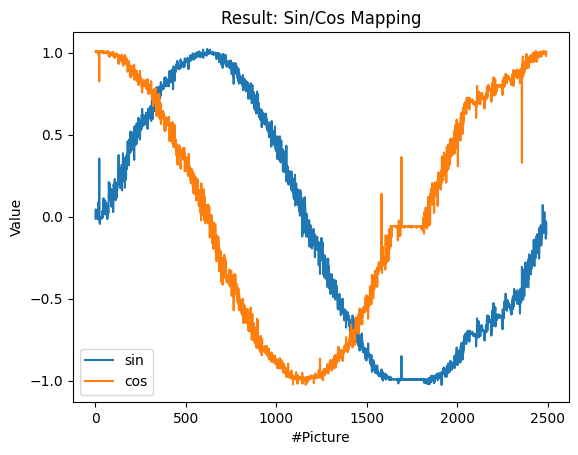

In [11]:
plt.plot(res[:,3])
plt.plot(res[:,4])
plt.title('Result: Sin/Cos Mapping')
plt.ylabel('Value')
plt.xlabel('#Picture')
plt.legend(['sin', 'cos'], loc='lower left')
plt.show()


### Save the model

In [12]:
FileName = f"{Output_Dir}/{TFlite_MainType}_{TFlite_Version}_{TFlite_Size}.tflite"

# TensorFlow Lite conversion
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model
with open(FileName, "wb") as f:
    f.write(tflite_model)

print(f"Model saved successfully. File: {FileName}")
print(f"File size: {Path(FileName).stat().st_size} bytes")


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpui9rsi7h\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpui9rsi7h\assets


Saved artifact at 'C:\Users\Muell\AppData\Local\Temp\tmpui9rsi7h'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  1496480869520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1496480867984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1496480868368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1496480867600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1496480869904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1496480869136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1496480867792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1496480870672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1496480868560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1496480867408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1496480

In [13]:
FileName = f"{Output_Dir}/{TFlite_MainType}_{TFlite_Version}_{TFlite_Size}_q.tflite"

# Representative dataset function
def representative_dataset():
    for n in range(x_data[0].shape[0]):
        data = np.expand_dims(x_data[n], axis=0)
        yield [data.astype(np.float32)]

# TensorFlow Lite conversion with optimizations
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter._experimental_disable_per_channel_quantization_for_dense_layers = True
tflite_quant_model = converter.convert()

# Save the converted model to the specified file
with open(FileName, "wb") as f:
    f.write(tflite_quant_model)

print(f"Model saved successfully. File: {FileName}")
print(f"File size: {Path(FileName).stat().st_size} bytes")


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpz0rd6e25\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpz0rd6e25\assets


Saved artifact at 'C:\Users\Muell\AppData\Local\Temp\tmpz0rd6e25'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  1496480869520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1496480867984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1496480868368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1496480867600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1496480869904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1496480869136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1496480867792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1496480870672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1496480868560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1496480867408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1496480

C:\Users\Muell\anaconda3\envs\py311-tf218\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
